<a href="https://colab.research.google.com/github/almonil/Proyecto/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto




Se importan las librerias

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.layers import Input, Dense
from keras.models import Model, load_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from keras.models import Model, load_model
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

Se carga el archivo de datos a manejar en este caso Credit_data.csv

In [ ]:
#Se carga el dataset a pandas dataframe
df= pd.read_csv('/content/credit_data.csv', delimiter=',')



Preprocesamiento de datos.

Aqui se ven ejemplos del dataframe y el uso de distintas librerias.

Ver los 5 mejores registros

In [ ]:
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,0.0,1.610,-1.951
1,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,0.0,-0.288,-1.951
2,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,0.0,4.570,-1.950
3,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,0.0,1.273,-1.950
4,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,0.0,0.581,-1.950


determinar el número de registros en el conjunto de datos

In [ ]:
print('El dataset contiene {0} filas and {1} columnas.'.format(df.shape[0], df.shape[1]))

El dataset contiene 49610 filas and 31 columnas.




Las características ya están escaladas y los nombres de las características no se muestran por razones de privacidad.


Ahora, veamos cuántas de las transacciones son fraudulentas.

loc localiza todos los datos por columna o declaración condicional


In [ ]:

fraudes = df.loc[df['Class'] == 1] # Encontrar todas las fillas del fraude
non_fraudes = df.loc[df['Class'] == 0] # final all rows that aren't fraudulent
print('Fraudes ', len(fraudes), '  transacciones realizadas  ', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('No Fraudes ', len(non_fraudes), '  transacciones realizadas  ', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

Fraudes  148   transacciones realizadas   99.7 % of the dataset
No Fraudes  49461   transacciones realizadas   0.3 % of the dataset


Sólo 492 de las transacciones son fraudulentas. Esto significa que el conjunto de datos está bastante desequilibrado; el 99,83% de las transacciones son normales. Los casos de fraude son anomalías y, por tanto, nuestro modelo realizará una detección de anomalías para averiguar qué transacciones son fraudulentas.

No queremos utilizar este marco de datos como base para nuestros modelos predictivos y análisis porque obtendremos muchos errores y nuestro modelo se sobreajustará, ya que asumirá que la mayoría de las transacciones no son fraudulentas. Esto nos obligará a modificar bastante el marco de datos más adelante para poder crear un modelo que prediga adecuadamente (patrones de) fraude.


Dos columnas Time y Amount con sus datos de precision no normalizadas


In [ ]:
#resumen numérico -> sólo columnas de interés no anonimizadas
pd.set_option('precision', 3)
df.loc[:, ['Time', 'Amount']].describe()

,Time,Amount
count,49610.000,49609.000
mean,28803.556,93.121
std,13097.469,253.266
min,0.000,0.000
25%,21734.250,7.610
50%,33390.000,25.000
75%,38852.750,85.000
max,44135.000,12910.930


Veamos las distribuciones:

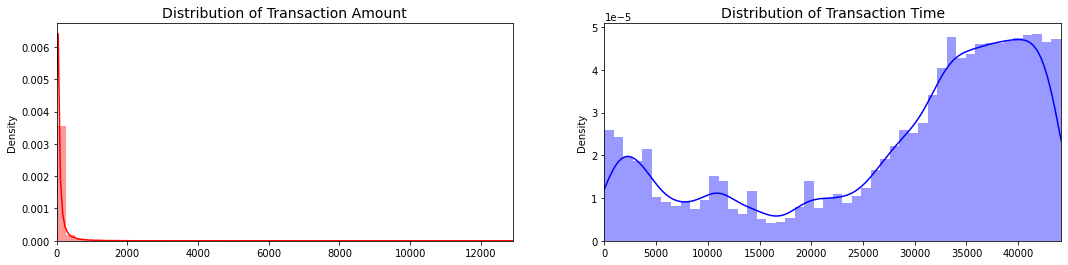

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

En ciertos momentos del tiempo se evidencia grandes cantidades de fraudes

In [ ]:
# separating the data for analysis
legit = df[df.Class == 0]
fraud = df[df.Class == 1]

In [ ]:
print(legit.shape)
print(fraud.shape)

(49461, 31)
(148, 31)


Text(0.5, 1.0, 'Mapa térmico de la correlación')

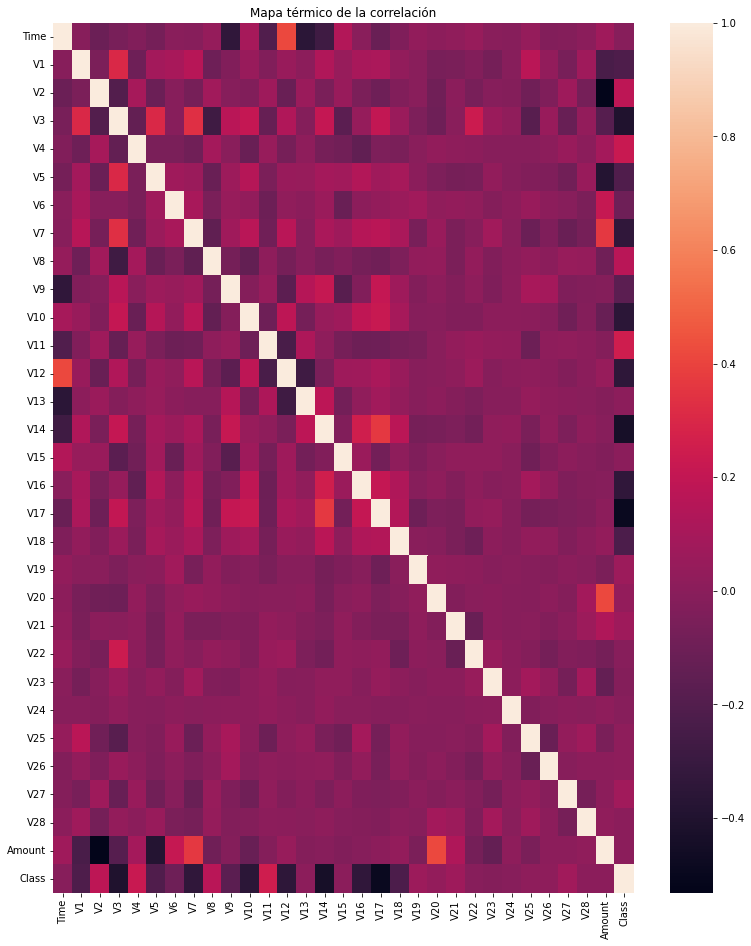

In [ ]:
corr = df.corr()

plt.figure(figsize=(13,16))
heat = sns.heatmap(data=corr)
plt.title('Mapa térmico de la correlación')

**Escalado y distribución**
Escalado: Vamos a escalar las columnas Tiempo y Cantidad.

Distribución: Crearemos una submuestra del marco de datos para tener una cantidad igual de casos de fraude y de no fraude. Esto ayudará a nuestro algoritmo a entender mejor los patrones que determinan si una transacción es un fraude o no.

La submuestra será un marco de datos con una proporción de 50/50 de transacciones fraudulentas y no fraudulentas. Esto es importante para evitar el sobreajuste y proporcionarnos las correlaciones correctas entre las características.

Tenemos que elegir al azar 492 casos de las transacciones no fraudulentas y colocarlos en nuestro nuevo marco de datos.

La mayoría de nuestros datos ya están escalados, así que sólo tenemos que escalar las características de Tiempo y Cantidad:


In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler es menos propenso a los valores atípicos.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True) # removing non-scaled time and


In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True) # eliminar del final
df.insert(0, 'scaled_amount', scaled_amount) # coloque la cantidad escalada en la columna 1
df.insert(1, 'scaled_time', scaled_time) # colocar el tiempo escalado en la columna 2

# ¡Cantidad y tiempo ahora son escalables!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.610,-1.951,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,0.0
1,-0.288,-1.951,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,0.0
2,4.570,-1.950,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,0.0
3,1.273,-1.950,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,0.0
4,0.581,-1.950,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,0.0


**Dividir los datos**

> Antes de realizar el submuestreo aleatorio, tenemos que crear nuestro conjunto de pruebas a partir del marco de datos original para poder probar nuestro modelo creado a partir del marco de datos submuestreado en el conjunto de pruebas del marco de datos origina


In [ ]:
df = df.sample(frac=1)

# amount of fraud classes
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
21372,-0.207,-0.103,-3.277,0.257,1.750,0.825,1.421,-1.650,-1.934,-3.405,-0.129,0.556,0.421,1.110,1.163,0.028,1.274,-0.161,0.253,-0.714,0.655,-1.649,2.458,-1.609,-0.858,1.033,-0.081,0.266,0.982,-0.090,0.0
44685,-0.310,0.506,-0.526,1.187,0.376,-0.004,1.386,-0.156,0.834,0.148,-0.801,-1.166,1.168,0.238,-0.038,-1.300,-0.022,0.837,0.396,0.953,-0.990,-0.103,0.101,0.279,-0.280,-0.811,-0.117,-0.499,0.169,0.174,0.0
44906,-0.013,0.511,-0.966,0.431,1.220,-1.712,-0.850,-1.198,-0.104,0.377,-1.292,-0.081,-0.773,-1.215,-0.804,0.196,0.206,1.458,0.204,-1.155,-0.054,0.092,0.199,0.282,-0.106,0.349,0.132,-0.386,0.183,0.079,0.0
32156,0.493,0.191,-0.534,0.227,1.621,-2.094,-0.498,-0.741,0.499,-0.065,0.793,-1.592,-0.701,0.080,0.121,0.016,1.822,-0.118,-0.436,0.388,0.978,0.169,0.016,-0.015,-0.087,-0.097,-0.019,-0.076,0.077,0.107,0.0
32581,3.729,0.203,0.526,-1.296,0.360,0.284,-0.809,0.610,-0.223,0.282,0.419,-0.287,1.545,0.922,-0.547,0.284,0.372,-0.199,0.217,-0.730,-0.409,0.465,0.217,0.071,-0.212,-0.208,-0.043,1.025,-0.090,0.044,0.0


Submuestreo y sobremuestreo aleatorios
Vamos a equilibrar nuestro conjunto de datos utilizando un submuestreo aleatorio.

Pasos:


> Determine cuán desequilibrada está nuestra clase. value_count() aplicado a Class funciona bien para esto. En nuestro caso, es de 492
Llevar el número de transacciones no fraudulentas al mismo que las transacciones fraudulentas.
Barajar los datos* para ver si nuestro modelo puede mantener una cierta precisión cada vez que ejecutamos nuestro script.
Obviamente, hay un problema con este método: como estamos eliminando tantas transacciones, nuestro conjunto de datos disminuye significativamente de tamaño y hay una pérdida de información.

Barajemos los datos antes de crear submuestras:



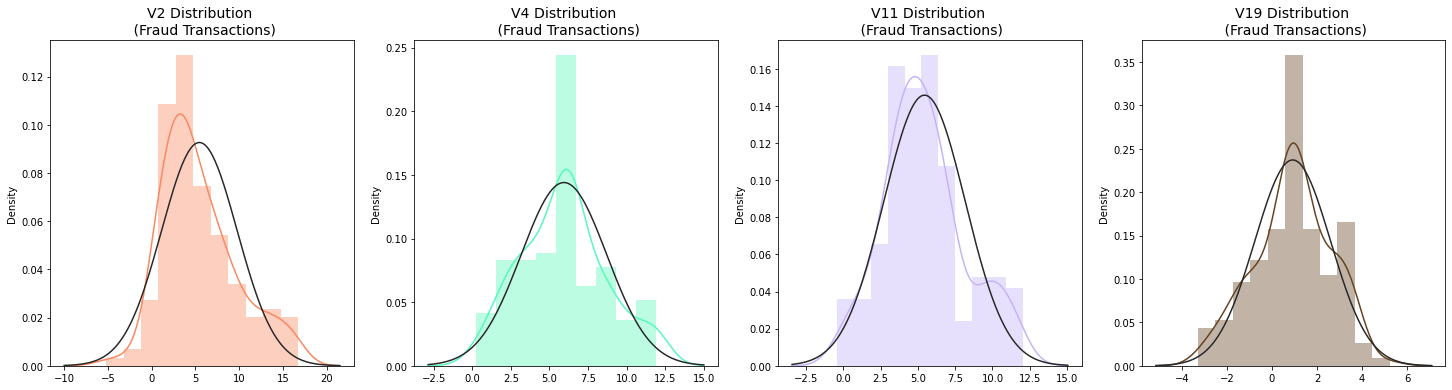

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 6))

V2_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1].values
sns.distplot(V2_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)

v4_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1].values
sns.distplot(v4_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)


v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(v11_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

v19_fraud_dist = new_df['V19'].loc[new_df['Class'] == 1].values
sns.distplot(v19_fraud_dist,ax=ax4, fit=norm, color='#654321')
ax4.set_title('V19 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

**Se inicia con el modelo de regression logistica**



In [ ]:
model = LogisticRegression()

In [ ]:
legit_sample = legit.sample(n=492)

In [ ]:
new_dataset = pd.concat([legit_sample, fraud], axis=0)

In [ ]:
X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']

In [ ]:
print(X)

       scaled_amount  scaled_time     V1     V2  ...    V25    V26    V27    V28
27415         -0.271        0.067  1.195 -0.124  ...  0.308  0.476 -0.051 -0.002
21064         -0.120       -0.114  1.130  0.070  ...  0.649 -0.308  0.029  0.002
41352          0.581        0.424 -1.177  1.239  ...  0.340 -0.124 -0.132 -0.159
29653          0.007        0.127  1.262 -0.395  ...  0.361 -0.305  0.036  0.030
28335          0.306        0.092  1.414 -1.053  ...  0.493 -0.117  0.016  0.002
...              ...          ...    ...    ...  ...    ...    ...    ...    ...
18773         -0.314       -0.212  0.270  3.550  ...  1.378  0.565  0.553  0.402
9035          -0.310       -1.215 -2.590  7.017  ... -0.690  0.632  1.934  0.790
41943         -0.313        0.438 -2.141  4.105  ...  1.364 -0.519  2.352  1.131
541           -0.323       -1.927 -2.312  1.952  ...  0.045  0.178  0.261 -0.143
9252          -0.310       -1.172 -5.454  8.287  ...  1.352  0.608  1.575  0.809

[640 rows x 30 columns]


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(640, 30) (512, 30) (128, 30)


**Evaluación del modelo**

**Puntuación de precisión**

In [ ]:
# Entrenamiento del modelo de regresión logística con datos de entrenamiento
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print('Precisión en los datos de entrenamiento : ', training_data_accuracy)

Precisión en los datos de entrenamiento :  0.98828125


In [ ]:
# precisión en los datos de entrenamiento
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [ ]:
# precisión en los datos de prueba
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Puntuación de precisión en los datos de la prueba : ', test_data_accuracy)

Puntuación de precisión en los datos de la prueba :  0.984375


In [ ]:
test_predictions=autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
y_pred=[(lambda er: 1 if er>=11.078922  else 0)(er) for er in mse]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class',1) , df['Class'], test_size=0.5, random_state=0)

In [89]:
y_test.value_counts()/y_test.count()

0.0    0.997
1.0    0.003
Name: Class, dtype: float64